Access and point-sample [ITS_LIVE](https://its-live.jpl.nasa.gov/) image-pair velocity data stored in cloud-based Zarr datacubes

In [23]:
# EXPECTED RUNTIME: 40 sec

import geopandas as gpd
import xarray as xr

# Metadata for output Dataset
VAR_ATTRS = {
    "cd": {
        "description": "Distance of point along centre flowline of glacier",
        "units": "metres from minimum observed terminus position (positive=upstream)",
    },
    "glacier": {
        "description": "Initials of glacier",
    },
    "v": {
        "description": "median velocity magnitude sampled within a 1x1 km box about point (x,y)",
        "units": "metre/year",
    },
    "v_error": {
        "description": "median velocity magnitude error sampled within a 1x1 km box about point (x,y)",
        "units": "metre/year",
    },
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
}

# Variables to extract from datacubes
VARIABLES = [
    "v",
    "v_error",
    "date_dt",
    "mid_date",
    "mission_img1",
    "satellite_img1",
    "acquisition_date_img1",
    "acquisition_date_img2",
    "mapping",
]

# Read, sort, and select centreline points used for sampling
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier", "cd"])
points = points.loc[points.cd.isin([1_000, 10_000])].reset_index()

# Read ITS_LIVE datacube catalog and reproject to EPSG:3413
its_live_catalog_url = "https://its-live-data.s3-us-west-2.amazonaws.com/datacubes/catalog_v02.json"
its_live_catalog = gpd.read_file(its_live_catalog_url).to_crs(3413)

# Overlay points with datacube catalog to get intersecting datacube URLs (and modify to s3 format)
points = points.overlay(its_live_catalog[["geometry", "zarr_url"]], how="intersection")
points["zarr_url"] = points.zarr_url.str.replace("http:", "s3:")
points["zarr_url"] = points.zarr_url.str.replace(".s3.amazonaws.com", "")

# Container for sampled Datasets
v_ds = []

# Group centreline points by intersecting datacube
for zarr_url, points_cube in points.groupby(by="zarr_url"):
    # Open datacube
    its_live = xr.open_dataset(zarr_url, engine="zarr", storage_options={"anon": True})

    # Group points by glacier
    for _, points_glacier in points_cube.groupby(by="glacier"):
        # Iterate over each point for current glacier
        for i, point in points_glacier.reset_index().iterrows():
            # Define slices for x and y bounds of 1km sampling box about point
            x = point.geometry.x
            y = point.geometry.y
            x_slice = slice(x - 500, x + 500)
            y_slice = slice(y + 500, y - 500)

            # Subset ITS_LIVE dataset by sampling box, selecting only variables of interest
            _v_ds = its_live[VARIABLES].sel(x=x_slice, y=y_slice)

            # Lazily sample median v and v_error
            _v_ds["v"] = _v_ds.v.median(dim=["x", "y"]).assign_attrs(VAR_ATTRS["v"])
            _v_ds["v_error"] = _v_ds.v_error.median(dim=["x", "y"]).assign_attrs(
                VAR_ATTRS["v_error"]
            )

            # Assign dimensions of current point as (glacier, cd)
            _v_ds = _v_ds.drop_dims(drop_dims=["x", "y"])
            _v_ds = _v_ds.expand_dims(dim=["glacier", "cd"])
            _v_ds = _v_ds.assign_coords(
                cd=("cd", [point.cd], VAR_ATTRS["cd"]),
                glacier=("glacier", [point.glacier], VAR_ATTRS["glacier"]),
                x=(("glacier", "cd"), [[point.geometry.x]], VAR_ATTRS["x"]),
                y=(("glacier", "cd"), [[point.geometry.y]], VAR_ATTRS["y"]),
            )
            v_ds.append(_v_ds)

# Concat sampled Datasets, sort by date, and write to disk
v_ds = xr.combine_nested(v_ds, concat_dim="mid_date", combine_attrs="drop_conflicts")
v_ds = v_ds.sortby("mid_date")
v_ds.to_netcdf("../data/velocity/velocity_subannual_1985_2022.nc")
v_ds

<xarray.Dataset> Size: 81MB
Dimensions:                (glacier: 2, cd: 2, mid_date: 348436)
Coordinates:
  * cd                     (cd) int32 8B 1000 10000
  * glacier                (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUN...
  * mid_date               (mid_date) datetime64[ns] 3MB 1984-11-23T13:26:21....
    x                      (glacier, cd) float64 32B 5.571e+05 ... 4.809e+05
    y                      (glacier, cd) float64 32B -1.896e+06 ... -2.43e+06
Data variables:
    v                      (glacier, cd, mid_date) float32 6MB nan ... 2.482e+03
    v_error                (glacier, cd, mid_date) float32 6MB nan nan ... 106.0
    date_dt                (glacier, cd, mid_date) timedelta64[ns] 11MB 400 d...
    mission_img1           (glacier, cd, mid_date) object 11MB 'L' 'L' ... 'S'
    satellite_img1         (glacier, cd, mid_date) object 11MB '5' '5' ... '1A'
    acquisition_date_img1  (glacier, cd, mid_date) datetime64[ns] 11MB 1984-0...
    acquisition_date_img2  (glacier, cd, mid_date) datetime64[ns] 11MB 1985-0...
    mapping                (mid_date, glacier, cd) object 11MB '' nan ... nan ''
Attributes:
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    projection:                 3413
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities

Quick visualisation of velocity time series

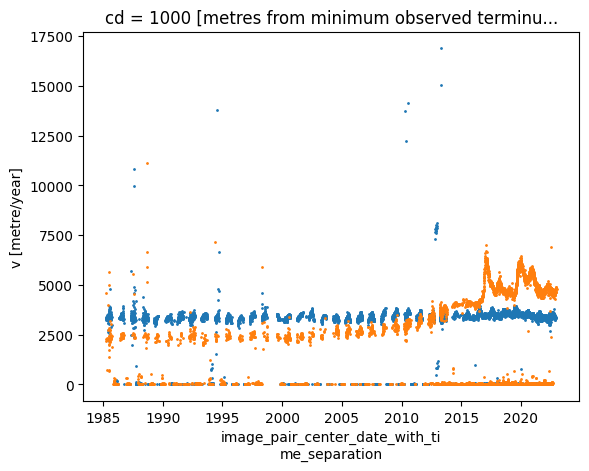

In [24]:
for _, ds in v_ds.sel(cd=1_000).groupby("glacier", squeeze=False):
    ds.v.dropna("mid_date").plot(linestyle="", marker="o", markersize=1)

Access and sample [ITS_LIVE](https://its-live.jpl.nasa.gov/) annual velocity mosaics along full glacier centrelines

In [25]:
# EXPECTED RUNTIME: 20 sec

import glob

import geopandas as gpd
import pandas as pd
import xarray as xr

# Metadata for output Dataset
ATTRS = {
    "cd": {
        "description": "Distance of point along centre flowline of glacier",
        "units": "metres from minimum observed terminus position (positive=upstream)",
    },
    "glacier": {
        "description": "Initials of glacier",
    },
    "v": {
        "description": "median velocity magnitude sampled within a 1x1 km box about point (x,y)",
        "units": "metre/year",
    },
    "v_error": {
        "description": "median velocity magnitude error sampled within a 1x1 km box about point (x,y)",
        "units": "metre/year",
    },
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
}

# Read, sort, and subset centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier", "cd"])
points = points.loc[points.cd.between(0, 20_000)].reset_index()

# Find file paths for all ITS_LIVE annual mosaics
files = glob.glob("../data/velocity/ITS_LIVE_velocity_120m_RGI05A_*_v02.nc")

# # OPTIONAL: Stream ITS_LIVE annual mosaics from S3 storage (avoids downloading ~35 GB)
# import s3fs
# its_live_s3 = s3fs.S3FileSystem(anon=True)
# its_live_s3_path = "s3://its-live-data/velocity_mosaic/v2/annual"
# files = its_live_s3.glob(f"{its_live_s3_path}/ITS_LIVE_velocity_120m_RGI05A_*_v02.nc")
# files = [its_live_s3.open(f, mode="rb") for f in files[1:]]

# Stack mosaics by year into lazy dask dataset
its_live = xr.open_mfdataset(files, concat_dim="time", combine="nested")

# To store point-sampled subsets of its_live
v_ds = []

# Group points by glacier
for _, points_glacier in points.groupby(by="glacier"):
    # Iterate over each point for current glacier
    for _, point in points_glacier.reset_index().iterrows():
        # Define slices for x and y bounds of 1km sampling box about point
        x = point.geometry.x
        y = point.geometry.y
        x_slice = slice(x - 500, x + 500)
        y_slice = slice(y + 500, y - 500)

        # Subset ITS_LIVE dataset by sampling box
        _v_ds = its_live.sel(x=x_slice, y=y_slice)

        # Sample median v and v_error (lazily)
        _v_ds["v"] = _v_ds.v.median(dim=["x", "y"]).assign_attrs(ATTRS["v"])
        _v_ds["v_error"] = _v_ds.v_error.median(dim=["x", "y"]).assign_attrs(ATTRS["v_error"])

        # Assign dimensions of current point as (glacier, cd), and
        # convert time dimension from index to datetime
        _v_ds = _v_ds.drop_dims(drop_dims=["x", "y"])
        _v_ds = _v_ds.expand_dims(dim=["glacier", "cd"])
        _v_ds = _v_ds.assign_coords(
            cd=("cd", [point.cd], ATTRS["cd"]),
            glacier=("glacier", [point.glacier], ATTRS["glacier"]),
            time=("time", [pd.to_datetime(i + 1985, format="%Y") for i in _v_ds.time.values]),
            x=(("glacier", "cd"), [[point.geometry.x]], ATTRS["x"]),
            y=(("glacier", "cd"), [[point.geometry.y]], ATTRS["y"]),
        )
        v_ds.append(_v_ds)

# Concat sampled Datasets and write to disk
v_ds = xr.combine_by_coords(v_ds, combine_attrs="drop_conflicts")
v_ds.to_netcdf("../data/velocity/velocity_annual_1985_2022.nc")
v_ds

<xarray.Dataset> Size: 77kB
Dimensions:  (glacier: 2, cd: 81, time: 38)
Coordinates:
  * cd       (cd) int32 324B 0 250 500 750 1000 ... 19250 19500 19750 20000
  * glacier  (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUNARTIT_ISLANDS'
  * time     (time) datetime64[ns] 304B 1985-01-01 1986-01-01 ... 2022-01-01
    x        (glacier, cd) float64 1kB 5.576e+05 5.575e+05 ... 4.74e+05
    y        (glacier, cd) float64 1kB -1.895e+06 -1.896e+06 ... -2.437e+06
Data variables:
    mapping  (glacier, cd, time) <U1 25kB '' '' '' '' '' '' ... '' '' '' '' ''
    v        (glacier, cd, time) float32 25kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    v_error  (glacier, cd, time) float32 25kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/14)
    author:                            ITS_LIVE, a NASA MEaSUREs project (its...
    datacube_autoRIFT_parameter_file:  http://its-live-data.s3.amazonaws.com/...
    institution:                       NASA Jet Propulsion Laboratory (JPL), ...
    region:                            RGI05A
    year:                              01-Jan-1985
    GDAL_AREA_OR_POINT:                Area
    ...                                ...
    title:                             ITS_LIVE annual mosaics of image pair ...
    date_created:                      15-Mar-2024 13:00:22
    latitude:                          [71.88]
    longitude:                         [-39.83]
    s3:                                s3://its-live-data/mosaics/annual/v2_s...
    url:                               http://its-live-data.s3.amazonaws.com/...

Quick visualisation of annual velocity time series

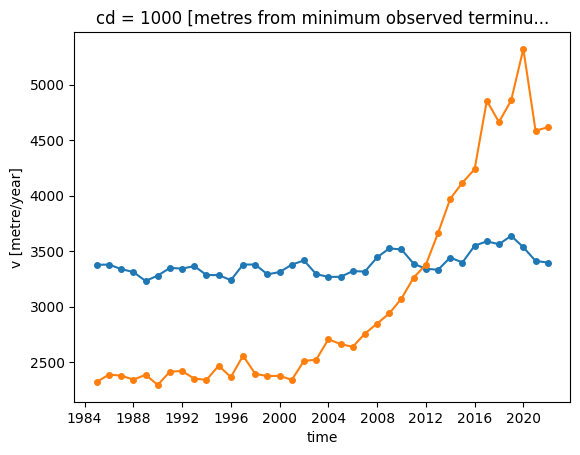

In [26]:
for _, ds in v_ds.sel(cd=1_000).groupby("glacier", squeeze=False):
    ds.v.plot(marker="o", markersize=4)

Quick visualisation of velocity profile along glacier centrelines (flow direction right to left)

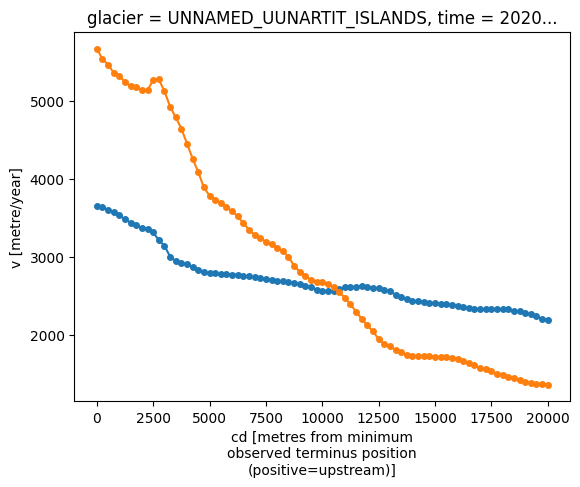

In [27]:
for _, ds in v_ds.sel(time="2020").groupby("glacier", squeeze=False):
    ds.v.plot(marker="o", markersize=4)

Quick visualisation of velocity profile time series, combining above to plots for Uunartit Islands (flow direction top to bottom)

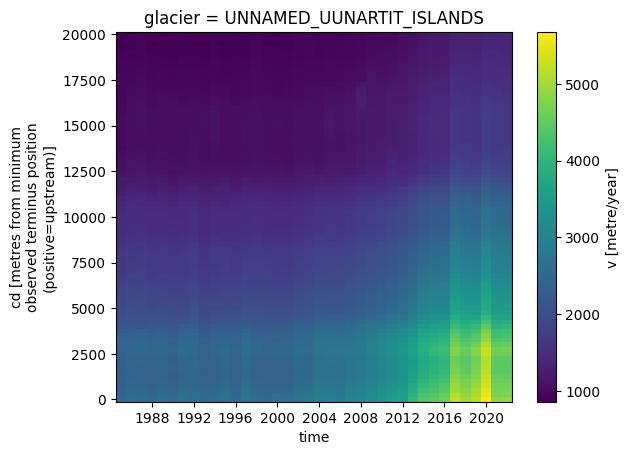

In [28]:
v_ds.sel(glacier="UNNAMED_UUNARTIT_ISLANDS").v.plot()